<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: Илья Барышников. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №2
## <center> Визуальный анализ данных о сердечно-сосудистых заболеваниях

**В задании предлагается с помощью визуального анализа ответить на несколько вопросов по данным о сердечно-сосудистых заболеваниях. Данные использовались в соревновании [Ml Boot Camp 5](http://mlbootcamp.ru/round/12/sandbox/) (качать их не надо, они уже есть в репозитории).**

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/H5uTYg).**

В соревновании предлагалось определить наличие/отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам осмотра пациента.

**Описание данных.**

Объективные признаки:

 - Возраст (age)
 - Рост (height)
 - Вес (weight)
 - Пол (gender)
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее (ap_hi, ap_lo)
 - Холестерин (cholesterol)
 - Глюкоза (gluc)
 

Субъективные признаки (со слов пациентов):

 - Курение (smoke)
 - Употребление алкоголя (alco)
 - Физическая активность (active)
 
Целевой признак (который интересно будет прогнозировать):
 - Наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра (cardio)

Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

In [1]:
# подгружаем все нужные пакеты
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

# настройка внешнего вида графиков в seaborn
sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18 
    }
)

# Проведем небольшой EDA

In [2]:
train = pd.read_csv('../../data/mlbootcamp5_train.csv', sep=';',
                    index_col='id')

In [3]:
print('Размер датасета: ', train.shape)
train.head()

Размер датасета:  (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Для начала всегда неплохо бы посмотреть на значения, которые принимают переменные.

Переведем данные в "Long Format"-представление и отрисуем с помощью [factorplot](https://seaborn.pydata.org/generated/seaborn.factorplot.html) количество значений, которые принимают категориальные переменные.

In [12]:
from IPython.display import display

train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active', 'cardio'])
display(train_uniques.head())

train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 
                                                    'value'])['value'].count())
display(train_uniques.head())

train_uniques = train_uniques.sort_index(level=[0, 1]) \
.rename(columns={'value': 'count'}) \
.reset_index()   
display(train_uniques.head(20))

,variable,value
0,gender,2
1,gender,1
2,gender,1
3,gender,2
4,gender,1


value
variable value       
active   0      13739
         1      56261
alco     0      66236
         1       3764
cardio   0      35021

,variable,value,count
0,active,0,13739
1,active,1,56261
2,alco,0,66236
3,alco,1,3764
4,cardio,0,35021
5,cardio,1,34979
6,cholesterol,1,52385
7,cholesterol,2,9549
8,cholesterol,3,8066
9,gender,1,45530


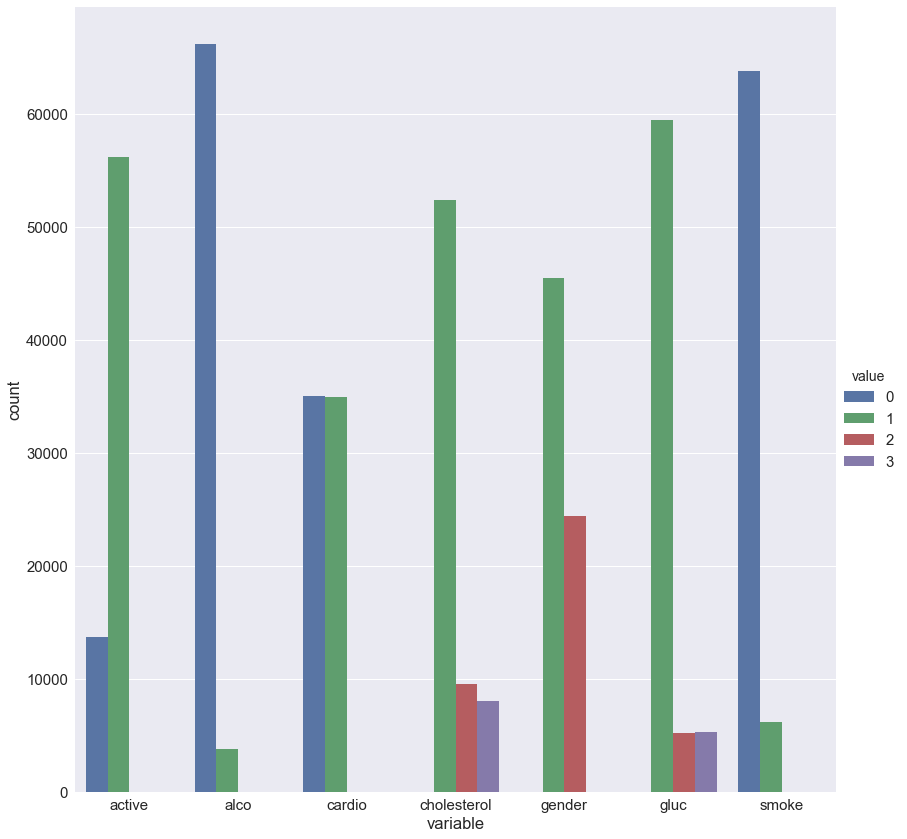

In [11]:
sns.factorplot(x='variable', y='count', hue='value', 
               data=train_uniques, kind='bar', size=12);

Видим, что классы целевой переменно сбалансированы, отлично!

Можно также разбить элементы обучающей выборки по значениям целевой переменной: иногда на таких графиках можно сразу увидеть самый значимый признак.

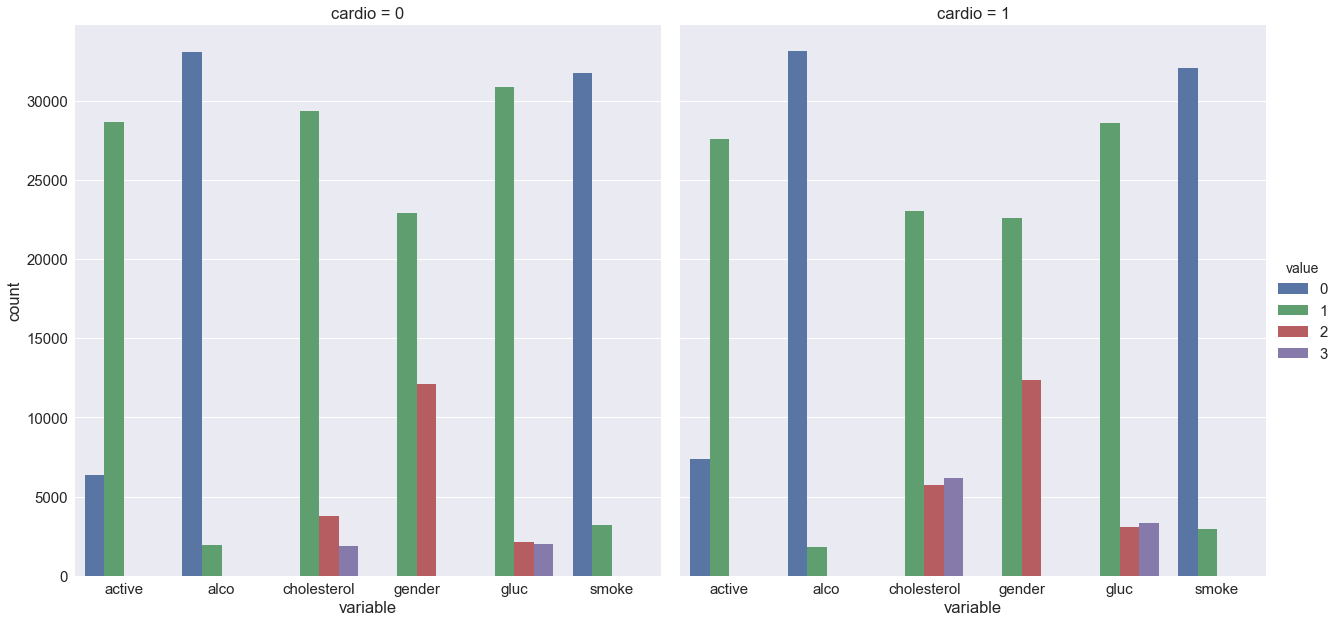

In [13]:
train_uniques = pd.melt(frame=train, value_vars=['gender','cholesterol', 
                                                 'gluc', 'smoke', 'alco', 
                                                 'active'], 
                        id_vars=['cardio'])
train_uniques = pd.DataFrame(train_uniques.groupby(['variable', 'value', 
                                                    'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()
    
sns.factorplot(x='variable', y='count', hue='value', 
               col='cardio', data=train_uniques, kind='bar', size=9);

Видим, что в зависимости от целевой переменной сильно меняется распределение холестерина и глюкозы. Совпадение?

**Немного статистики по уникальным значениям признаков.**

In [14]:
for c in train.columns:
    n = train[c].nunique()
    print(c)
    
    if n <= 3:
        print(n, sorted(train[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


*Итого:*
- Пять количественных признаков (без id)
- Семь категориальных
- 70000 элементов

---

# 1. Визуализируем корреляционную матрицу

Для того, чтобы лучше понять признаки в датасете, можно посчитать матрицу коэффициентов корреляции между признаками. <br>

Постройте [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html) корреляционной матрицы. Матрица формируется средствами *pandas*, со стандартным значением параметров.

###  1. Какие два признака больше всего коррелируют (по Пирсону) с признаком `gender` ?

- Cardio, Cholesterol
- Height, Smoke
- Smoke, Alco
- Height, Weight

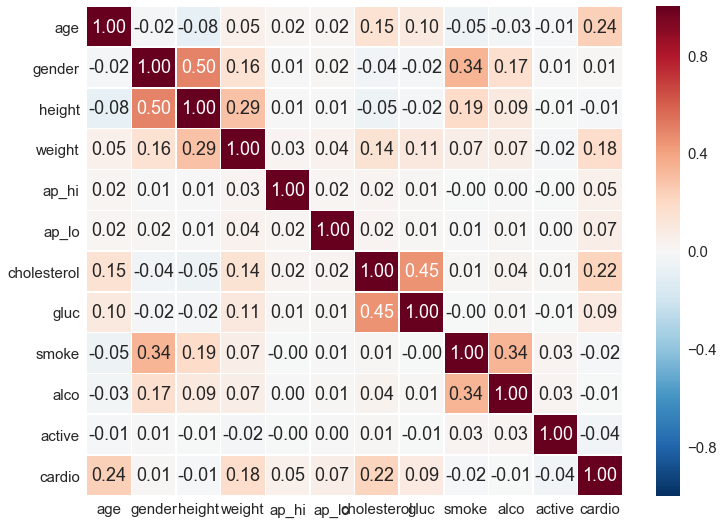

In [17]:
# Ваш код здесь
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=.5);

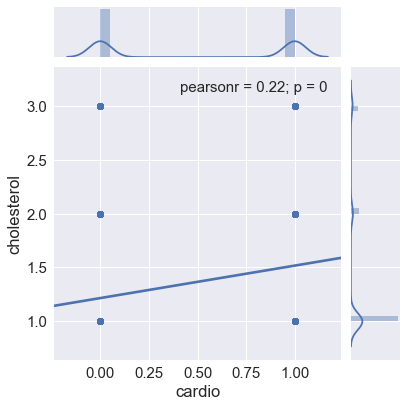

In [24]:
pairs = [['cardio', 'cholesterol'],
         ['height', 'smoke'],
         ['smoke', 'alco'],
         ['height', 'weight']]

for i in range(len(pairs)):
    sns.jointplot(x=pairs[i][0], y=pairs[i][1], data=train, kind='reg')
    break
#sns.jointplot(x='cardio', y='cholesterol', 
#              data=train, kind='reg');

---

# 2. Распределение роста для мужчин и женщин

Как мы увидели, в процессе исследования уникальных значений, пол кодируется значениями 1 и 2, расшифровка изначально не была нам дана в описании данных, но мы догадались, кто есть кто, посчитав средние значения роста (или веса) при разных значениях признака `gender`. Теперь сделаем то же самое, но графически. 

Постройте [violinplot](https://seaborn.pydata.org/generated/seaborn.violinplot.html) для роста и пола. Используйте:
- hue – для разбивки по полу
- scale – для оценки количества каждого из полов 

Для корректной отрисовки, преобразуйте DataFrame в "Long Format"-представление с помощью функции melt в pandas.
<br>
[еще один пример](https://stackoverflow.com/a/41575149/3338479)

Постройте на одном графике два отдельных [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) роста, отдельно для мужчин и женщин. На нем разница будет более наглядной, но нельзя будет оценить количество мужчин/женщин.

,gender,variable,height
0,2,height,168
1,1,height,156
2,1,height,165
3,2,height,169
4,1,height,156


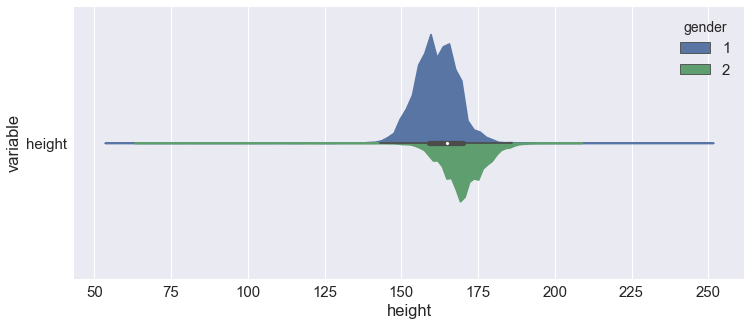

In [51]:
# Ваш код здесь
df = pd.melt(train, value_vars=['height'], id_vars='gender')
df.rename(columns={'value': 'height'}, inplace=True)
display(df.head())
plt.figure(figsize=(12, 5))
sns.violinplot(y='variable', x='height', data=df, hue='gender', split=True, scale="count");
plt.show()

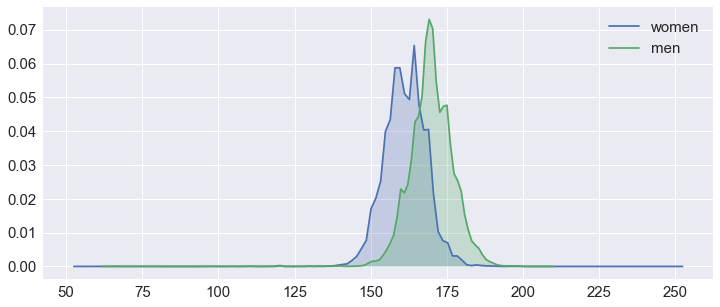

In [61]:
plt.figure(figsize=(12, 5))
ax = sns.kdeplot(train[train.gender == 1].height, shade=True, shade_lowest=False, label='women')
ax = sns.kdeplot(train[train.gender == 2].height, shade=True, shade_lowest=False, label='men')
plt.show()

---

# 3. Ранговая корреляция

В большинстве случаев достаточно воспользоваться линейным коэффициентом корреляции *Пирсона* для выявления закономерностей в данных, но мы пойдем чуть дальше и используем ранговую корреляцию, которая поможет нам выявить пары, в которых меньший ранг из вариационного ряда одного признака всегда предшествует большему другого (или наоборот, в случае отрицательной корреляции).

** Постройте корреляционную матрицу, используя коэффициент Спирмена**

### 3.1 Какие признаки теперь больше всего коррелируют (по Спирмену) друг с другом?

- Height, Weight
- Age, Weight
- Cholesterol, Gluc
- Cardio, Cholesterol
- Ap_hi, Ap_lo
- Smoke, Alco

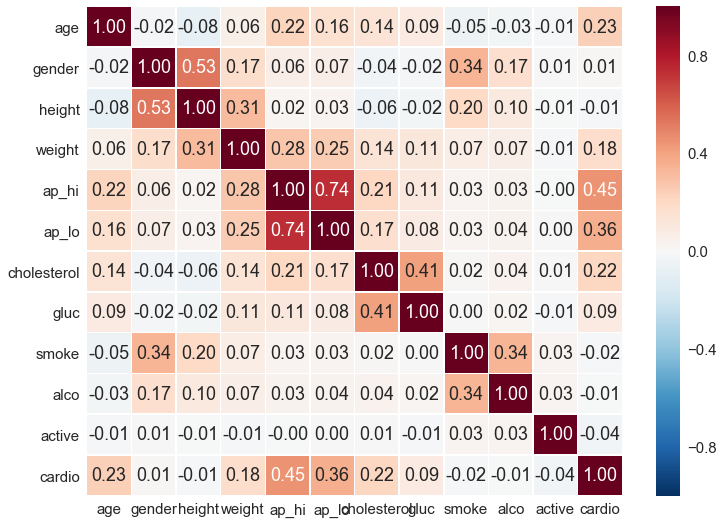

In [26]:
# Ваш код здесь
corr = train.corr(method='spearman')
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5);

### 3.2 Почему мы получили такое большое (относительно) значение ранговой корреляции у этих признаков?

- Неточности в данных (ошибки при сборе данных)
- Связь ошибочна, переменные никак не должны быть связаны друг с другом
- Природа данных

In [ ]:
# Ваш код здесь

---

# 4. Совместное распределение признаков

Постройте совместный график распределения [jointplot](http://seaborn.pydata.org/generated/seaborn.jointplot.html) двух наиболее коррелирующих между собой признаков (по Спирмену).

Кажется, наш график получился неинформативным из-за выбросов в значениях. Постройте тот же график, но с логарифмической шкалой.

In [77]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.00000,17664.000000,19703.000000,21327.00000,23713.000000
gender,70000.0,1.349571,0.476838,1.00000,1.000000,1.000000,2.00000,2.000000
height,70000.0,164.359229,8.210126,55.00000,159.000000,165.000000,170.00000,250.000000
weight,70000.0,74.205690,14.395757,10.00000,65.000000,72.000000,82.00000,200.000000
ap_hi,70000.0,128.817286,154.011419,-150.00000,120.000000,120.000000,140.00000,16020.000000
ap_lo,70000.0,96.630414,188.472530,-70.00000,80.000000,80.000000,90.00000,11000.000000
cholesterol,70000.0,1.366871,0.680250,1.00000,1.000000,1.000000,2.00000,3.000000
gluc,70000.0,1.226457,0.572270,1.00000,1.000000,1.000000,1.00000,3.000000
smoke,70000.0,0.088129,0.283484,0.00000,0.000000,0.000000,0.00000,1.000000
alco,70000.0,0.053771,0.225568,0.00000,0.000000,0.000000,0.00000,1.000000


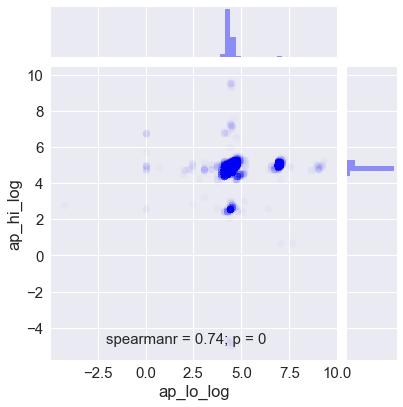

In [117]:
# Ваш код здесь

from scipy.stats import spearmanr

train['ap_hi_log'] = np.log(1 + train['ap_hi'].apply(abs)) * np.sign(train['ap_hi'])
train['ap_lo_log'] = np.log(1 + train['ap_lo'].apply(abs)) * np.sign(train['ap_lo'])

from matplotlib import pyplot

#fig, ax = pyplot.subplots(figsize=(16, 6))
#plt.scatter(train.ap_lo_log, train.ap_hi_log)
g = sns.jointplot('ap_lo_log', 'ap_hi_log', data=train, stat_func=spearmanr, color=(0, 0, 1, 0.02))

#ax = g.ax_joint
#ax.set_xscale('log')
#ax.set_yscale('log')
#g.ax_marg_x.set_xscale('log')
#g.ax_marg_y.set_yscale('log')


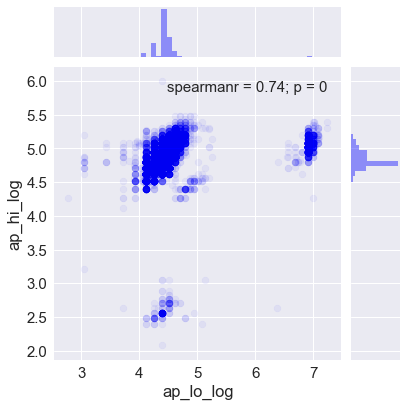

In [108]:
ind = (train.ap_lo_log < 6) & (train.ap_lo_log > 3)
ind = ind & (train.ap_hi_log < 6) & (train.ap_hi_log > 4)

ind0 = (train.ap_lo_log < 7.5) & (train.ap_lo_log > 2.5)
ind0 = ind0 & (train.ap_hi_log < 6) & (train.ap_hi_log > 2)
g = sns.jointplot('ap_lo_log', 'ap_hi_log', data=train[ind0], stat_func=spearmanr, color=(0, 0, 1, 0.05))

### 4.1 Сколько четко выраженных кластеров получилось на  совместном графике выбранных признаков, с логарифмической шкалой?

- 1
- 2
- 3
- больше трех

In [91]:
# Ваш код здесь
ind1 = (train.ap_lo_log > 6) & (train.ap_lo_log < 7.5)
print(sum(ind1))
display(train[ind1].head(20))

ind2 = (train.ap_lo_log > 7.5)
print(sum(ind2))
display(train[ind2].head(20))

ind3 = (train.ap_hi_log < 3.5)
print(sum(ind3))
display(train[ind3].head(20))

ind4 = (train.ap_hi_log > 6)
print(sum(ind4))
display(train[ind4].head(20))

ind5 = ind & (train.ap_hi_log < train.ap_lo_log)
print(sum(ind5))
display(train[ind5].head(20))


926


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_hi_log,ap_lo_log
id,,,,,,,,,,,,,,
314,17489,2,183,98.0,160,1100,1,2,1,0,1,1,5.081404,7.003974
334,21932,2,157,60.0,160,1000,2,1,0,0,0,1,5.081404,6.908755
357,18217,1,150,83.0,140,800,1,1,0,0,1,1,4.948760,6.685861
458,23407,1,176,63.0,160,1000,2,2,0,0,0,1,5.081404,6.908755
482,18704,1,154,81.0,140,1000,2,1,0,0,1,1,4.948760,6.908755
680,15226,1,150,95.0,150,1033,1,1,0,0,1,1,5.017280,6.941190
805,20430,2,173,101.0,200,1000,1,1,0,0,1,1,5.303305,6.908755
886,18963,1,165,92.0,140,1000,1,1,1,0,1,1,4.948760,6.908755
928,18190,1,166,57.0,190,1100,1,1,0,0,1,1,5.252273,7.003974


27


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_hi_log,ap_lo_log
id,,,,,,,,,,,,,,
3352,20994,2,186,105.0,140,10000,1,1,0,0,1,1,4.948760,9.210440
4208,20398,1,168,78.0,140,8044,3,3,0,0,0,1,4.948760,8.992806
9482,19528,1,162,69.0,130,9100,1,1,0,0,1,1,4.875197,9.116140
12494,16905,2,163,63.0,1,2088,1,1,1,0,1,0,0.693147,7.644441
13066,19078,1,165,71.0,120,8000,1,1,0,0,1,1,4.795791,8.987322
17260,21466,2,169,78.0,130,9011,1,1,1,1,1,1,4.875197,9.106312
20438,18381,1,160,70.0,160,7100,1,1,0,1,1,1,5.081404,8.867991
22832,14508,2,179,70.0,120,8500,1,1,0,0,1,0,4.795791,9.047939
25348,19573,1,151,57.0,140,8099,1,1,0,0,0,0,4.948760,8.999619


188


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_hi_log,ap_lo_log
id,,,,,,,,,,,,,,
815,21281,1,168,78.0,14,90,2,1,0,0,1,1,2.708050,4.510860
1294,21867,2,175,70.0,14,90,3,1,0,0,1,1,2.708050,4.510860
1360,18225,1,172,65.0,11,80,1,3,0,0,1,0,2.484907,4.394449
2260,19201,1,165,66.0,12,80,1,1,0,0,1,0,2.564949,4.394449
2301,22591,1,165,71.0,14,80,1,1,0,0,1,1,2.708050,4.394449
2505,14365,2,168,64.0,11,60,1,1,1,1,1,0,2.484907,4.110874
3057,21945,2,169,75.0,14,80,2,1,0,0,1,1,2.708050,4.394449
3112,21776,2,187,80.0,12,80,1,1,1,0,1,0,2.564949,4.394449
3424,18472,2,165,84.0,14,80,1,1,0,0,1,1,2.708050,4.394449


38


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_hi_log,ap_lo_log
id,,,,,,,,,,,,,,
2654,15116,1,160,60.0,902,60,1,1,0,0,1,0,6.805723,4.110874
2845,22712,2,167,59.0,906,0,1,1,0,0,1,0,6.810142,0.000000
6822,14425,1,168,63.0,909,60,2,1,0,0,1,0,6.813445,4.110874
11089,21032,1,175,80.0,11500,90,1,1,0,0,1,1,9.350189,4.510860
12710,18870,1,164,75.0,1420,80,2,1,0,0,1,1,7.259116,4.394449
13616,22659,1,155,87.0,701,110,1,1,0,0,1,1,6.553933,4.709530
19827,15996,1,168,72.0,1500,80,1,1,0,0,1,1,7.313887,4.394449
25314,22398,2,163,50.0,907,70,3,3,0,0,1,1,6.811244,4.262680
34120,16131,1,161,92.0,906,0,2,1,0,0,1,1,6.810142,0.000000


101


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_hi_log,ap_lo_log
id,,,,,,,,,,,,,,
681,19099,1,156,65.0,120,150,2,1,0,0,1,0,4.795791,5.017280
913,20457,2,169,68.0,70,110,1,1,0,0,1,0,4.262680,4.709530
3356,23361,1,154,102.0,90,150,1,1,0,0,0,1,4.510860,5.017280
4214,21957,2,182,90.0,80,140,3,3,0,0,1,1,4.394449,4.948760
4880,19992,2,180,80.0,80,125,3,3,1,1,1,1,4.394449,4.836282
5130,21874,1,160,83.0,80,120,1,1,0,0,1,0,4.394449,4.795791
6836,19618,2,164,89.0,90,140,2,2,0,0,1,1,4.510860,4.948760
6843,16969,2,159,68.0,70,100,1,1,0,0,0,0,4.262680,4.615121
6992,20501,1,160,69.0,80,170,1,1,0,0,1,1,4.394449,5.141664


---

# 5. Barplot

Посчитаем, сколько полных лет было респондентам на момент их занесения в базу.

In [106]:
train['age_years'] = (train['age'] // 365.25).astype(int)

Постройте [Countplot](http://seaborn.pydata.org/generated/seaborn.countplot.html), где на оси абсцисс будет отмечен возраст, на оси ординат – количество. Каждое значение возраста должно иметь два столбца, соответствующих количеству человек каждого класса **cardio** данного возраста.

### 5. В каком возрасте количество пациентов с ССЗ  впервые становится больше, чем здоровых?
- 44
- 53
- 64
- 70

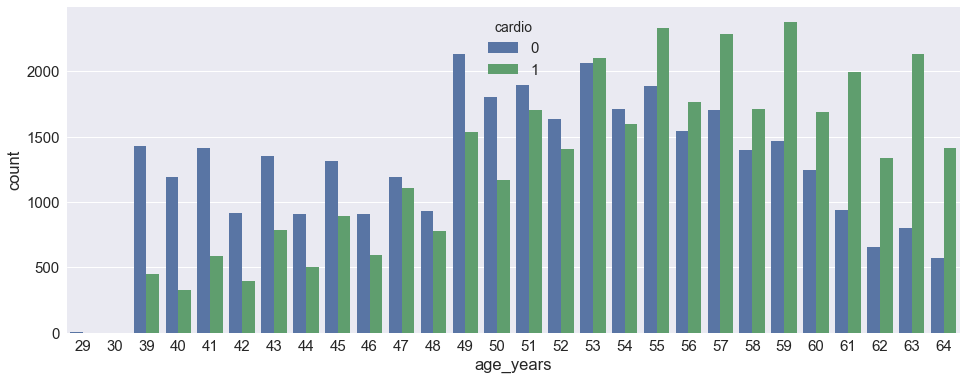

In [118]:
# Ваш код здесь
sns.countplot(x='age_years', hue='cardio', data=train);